In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

file = 'save'
train_size = 78*10**6
d = 5

#### Trend of loss & Sqc

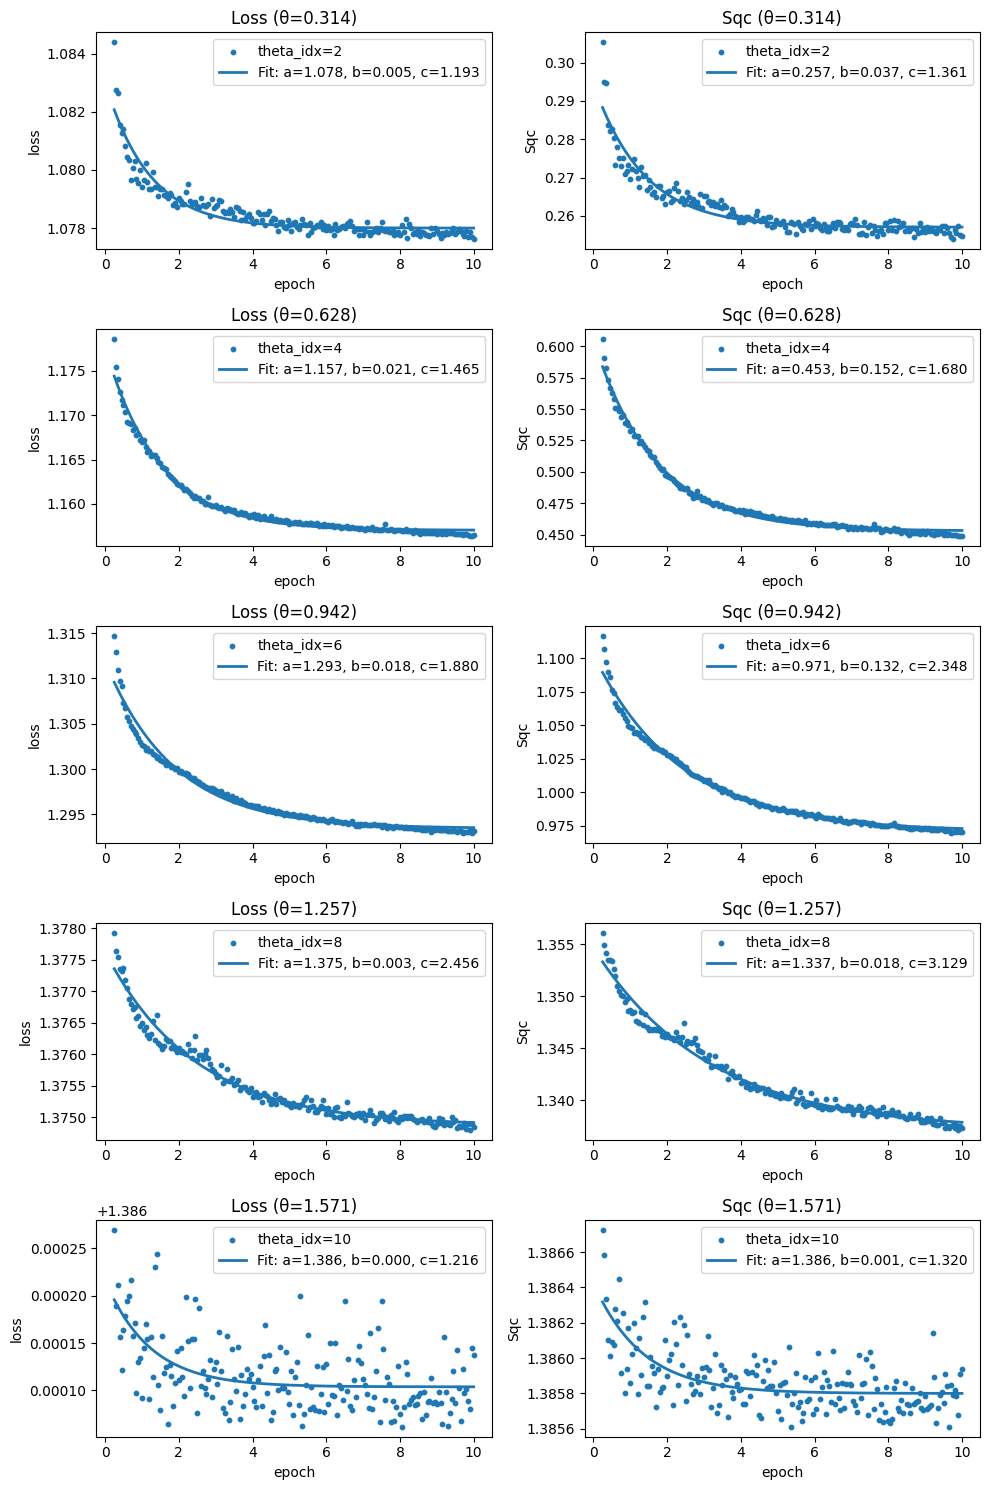

In [46]:
epoch_max = 9
cut_off = 5 # at least cut off the first point, since this is the initial loss before training
p0 = [1,5,5]

# Define fitting function
def exp_decay(x, a, b, c):
    return a + b * np.exp(-x / c)

fitting_result = {}

# Define theta indices to process
theta_indices = [2,4,6,8,10]

# Convert theta_idx to actual theta values
theta_values_all = torch.linspace(0, torch.pi/2, 11)
theta_values = [theta_values_all[idx].item() for idx in theta_indices]

# Create subplot grid: rows for different theta, columns for loss/Sqc
fig, axes = plt.subplots(nrows=len(theta_indices), ncols=2, figsize=(10, 3*len(theta_indices)))
if len(theta_indices) == 1:
    axes = axes.reshape(1, -1)  # Ensure 2D array for single row

for i, theta_idx in enumerate(theta_indices):
    l_train = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_train.pt')
    l_test = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_test.pt')
    Sqc_test = l_test['msk off Sqc']
    loss_train = l_train['loss']
    loss_test = l_test['loss']

    # Fit test loss
    x_loss = np.arange(len(loss_test))[cut_off:]/20
    y_loss = np.array(loss_test)[cut_off:]
    popt_loss, pcov_loss = curve_fit(exp_decay, x_loss, y_loss, p0=p0)
    # Fit test Sqc
    x_Sqc = np.arange(len(Sqc_test))[cut_off:]/20
    y_Sqc = np.array(Sqc_test)[cut_off:]
    popt_Sqc, pcov_Sqc = curve_fit(exp_decay, x_Sqc, y_Sqc, p0=p0)
    fitting_result[theta_idx] = {
        'loss': {
            'a': popt_loss[0],
            'b': popt_loss[1],
            'c': popt_loss[2]
        },
        'Sqc': {
            'a': popt_Sqc[0],
            'b': popt_Sqc[1],
            'c': popt_Sqc[2]
        }
    }
    
    # Loss plot (left column)
    axes[i, 0].scatter(x_loss, y_loss, s=10, label=f'theta_idx={theta_idx}')
    axes[i, 0].plot(x_loss, exp_decay(x_loss, *popt_loss), linewidth=2, 
                    label=f'Fit: a={popt_loss[0]:.3f}, b={popt_loss[1]:.3f}, c={popt_loss[2]:.3f}')
    axes[i, 0].set_xlabel('epoch')
    axes[i, 0].set_ylabel('loss')
    axes[i, 0].legend()
    axes[i, 0].set_title(f'Loss (θ={theta_values[i]:.3f})')
    # axes[i, 0].set_ylim(1.07, 1.39)  # Set y-axis range for loss plots
    
    # Sqc plot (right column)
    axes[i, 1].scatter(x_Sqc, y_Sqc, s=10, label=f'theta_idx={theta_idx}')
    axes[i, 1].plot(x_Sqc, exp_decay(x_Sqc, *popt_Sqc), linewidth=2,
                    label=f'Fit: a={popt_Sqc[0]:.3f}, b={popt_Sqc[1]:.3f}, c={popt_Sqc[2]:.3f}')
    axes[i, 1].set_xlabel('epoch')
    axes[i, 1].set_ylabel('Sqc')
    axes[i, 1].legend()
    axes[i, 1].set_title(f'Sqc (θ={theta_values[i]:.3f})')
    # axes[i, 1].set_ylim(0.25, 1.3)  # Set y-axis range for Sqc plots

plt.tight_layout()
plt.show()

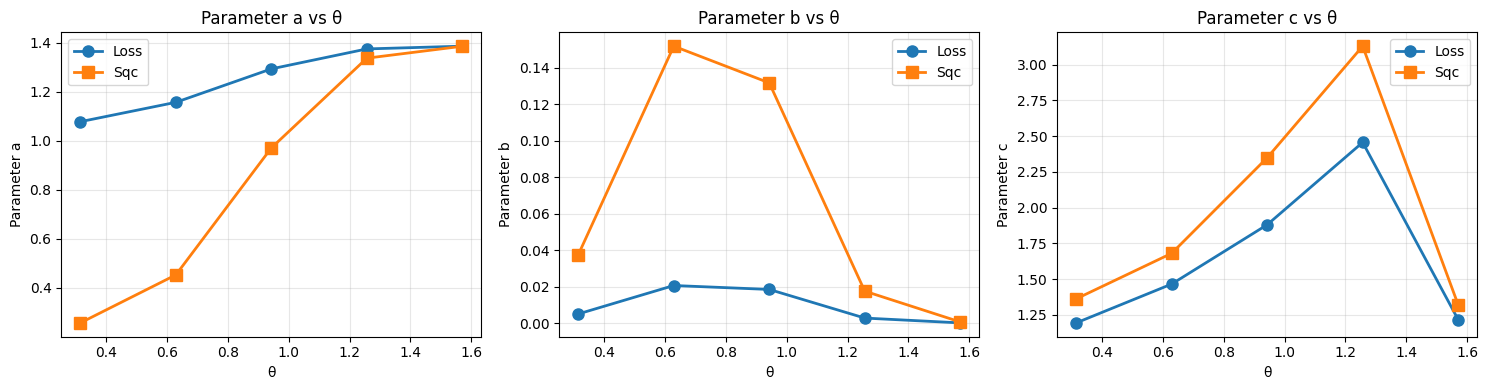

In [47]:
# Plot fitted parameters vs theta
# Convert theta_idx to actual theta values
theta_values_all = torch.linspace(0, torch.pi/2, 11)
theta_values = [theta_values_all[idx].item() for idx in theta_indices]

# Extract fitted parameters
loss_a = [fitting_result[idx]['loss']['a'] for idx in theta_indices]
loss_b = [fitting_result[idx]['loss']['b'] for idx in theta_indices]
loss_c = [fitting_result[idx]['loss']['c'] for idx in theta_indices]

Sqc_a = [fitting_result[idx]['Sqc']['a'] for idx in theta_indices]
Sqc_b = [fitting_result[idx]['Sqc']['b'] for idx in theta_indices]
Sqc_c = [fitting_result[idx]['Sqc']['c'] for idx in theta_indices]

# Create three separate figures
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot parameter a
axes[0].plot(theta_values, loss_a, 'o-', label='Loss', linewidth=2, markersize=8)
axes[0].plot(theta_values, Sqc_a, 's-', label='Sqc', linewidth=2, markersize=8)
axes[0].set_xlabel('θ')
axes[0].set_ylabel('Parameter a')
axes[0].set_title('Parameter a vs θ')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot parameter b
axes[1].plot(theta_values, loss_b, 'o-', label='Loss', linewidth=2, markersize=8)
axes[1].plot(theta_values, Sqc_b, 's-', label='Sqc', linewidth=2, markersize=8)
axes[1].set_xlabel('θ')
axes[1].set_ylabel('Parameter b')
axes[1].set_title('Parameter b vs θ')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot parameter c
axes[2].plot(theta_values, loss_c, 'o-', label='Loss', linewidth=2, markersize=8)
axes[2].plot(theta_values, Sqc_c, 's-', label='Sqc', linewidth=2, markersize=8)
axes[2].set_xlabel('θ')
axes[2].set_ylabel('Parameter c')
axes[2].set_title('Parameter c vs θ')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


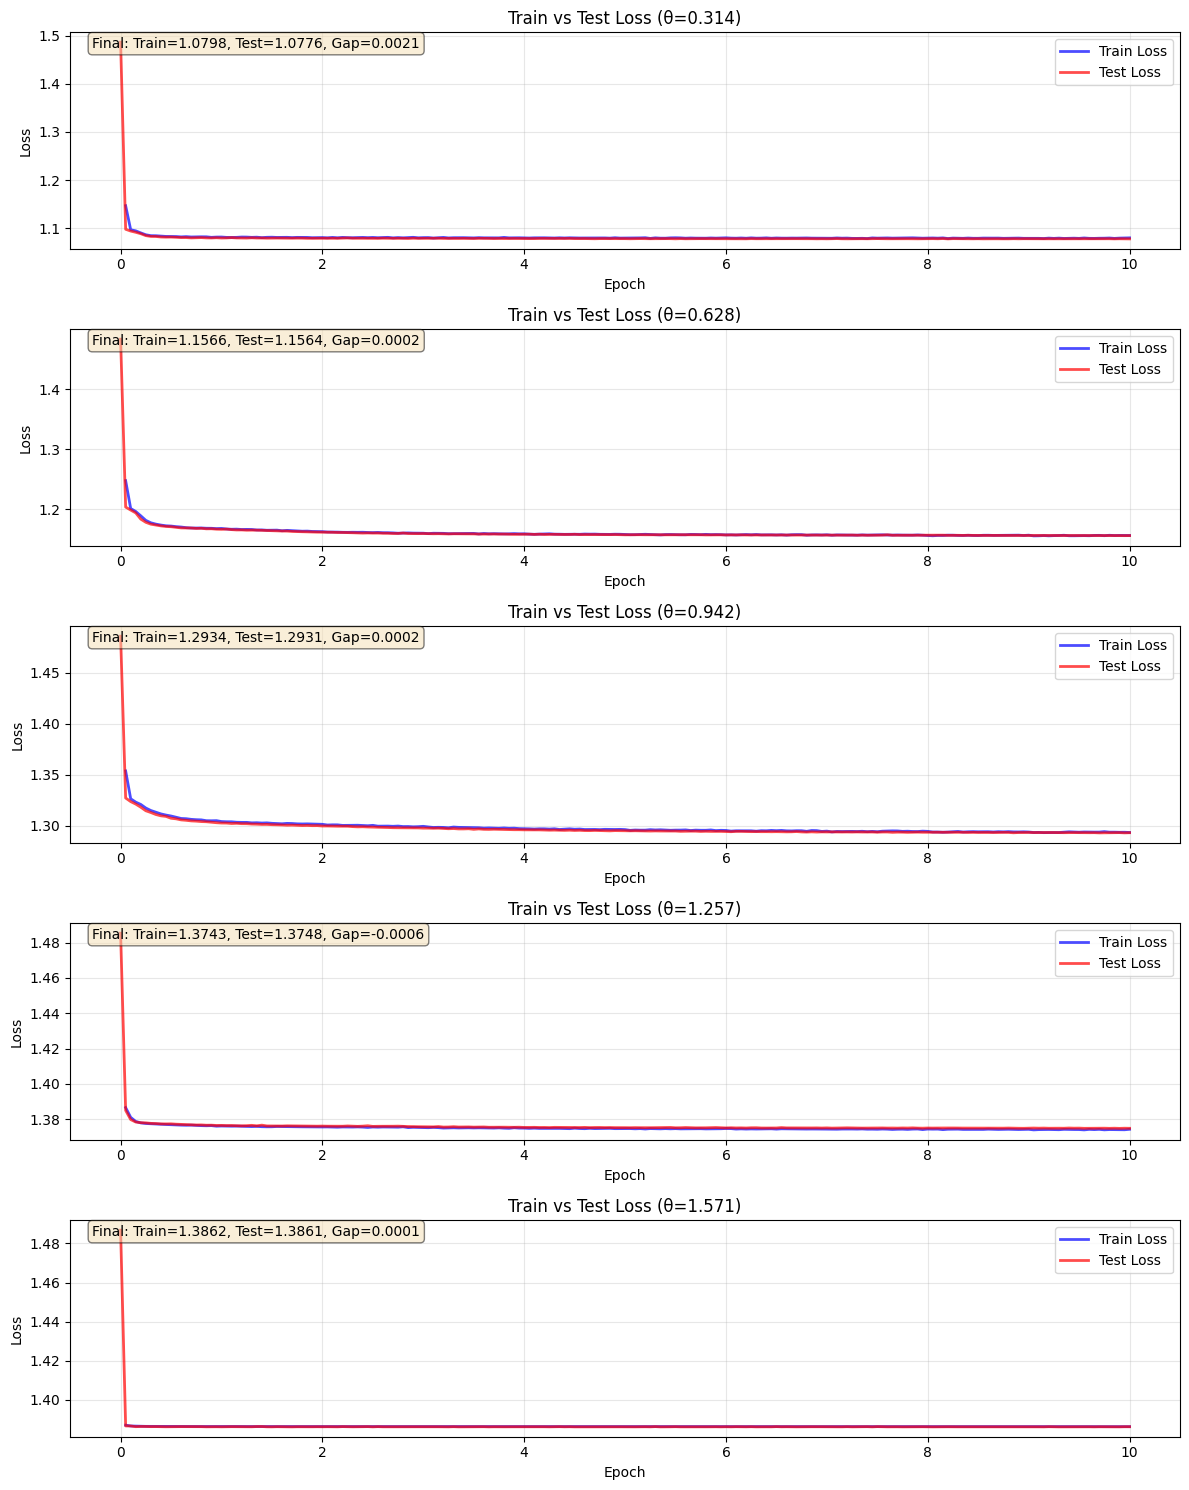

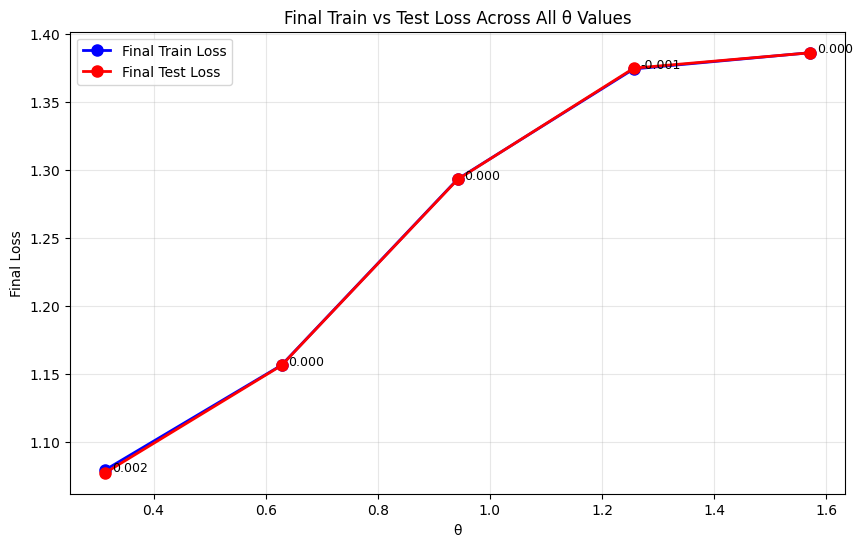

In [48]:
# Compare train loss vs test loss for all thetas to check overfitting
fig, axes = plt.subplots(nrows=len(theta_indices), ncols=1, figsize=(12, 3*len(theta_indices)))
if len(theta_indices) == 1:
    axes = [axes]  # Ensure axes is iterable for single subplot

for i, theta_idx in enumerate(theta_indices):
    # Load data
    l_train = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_train.pt')
    l_test = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_test.pt')
    
    train_loss = l_train['loss']
    test_loss = l_test['loss']
    
    # Create x-axis (epochs)
    x_train = np.arange(len(train_loss)) / 20  # Convert to epochs
    x_test = np.arange(len(test_loss)) / 20    # Convert to epochs
    
    # Plot train and test loss
    axes[i].plot(x_train, train_loss, 'b-', label='Train Loss', linewidth=2, alpha=0.7)
    axes[i].plot(x_test, test_loss, 'r-', label='Test Loss', linewidth=2, alpha=0.7)
    
    # Add labels and title
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Train vs Test Loss (θ={theta_values[i]:.3f})')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Add text showing final values
    final_train = train_loss[-1]
    final_test = test_loss[-1]
    gap = final_train - final_test
    axes[i].text(0.02, 0.98, f'Final: Train={final_train:.4f}, Test={final_test:.4f}, Gap={gap:.4f}', 
                transform=axes[i].transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Summary plot: Final train vs test loss for all thetas
fig, ax = plt.subplots(figsize=(10, 6))
final_train_losses = []
final_test_losses = []

for i, theta_idx in enumerate(theta_indices):
    l_train = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_train.pt')
    l_test = torch.load(f'{file}/record/epoch={epoch_max}_d={d}_theta_idx={theta_idx}_size{train_size}_test.pt')
    
    final_train_losses.append(l_train['loss'][-1])
    final_test_losses.append(l_test['loss'][-1])

# Plot final losses
ax.plot(theta_values, final_train_losses, 'bo-', label='Final Train Loss', linewidth=2, markersize=8)
ax.plot(theta_values, final_test_losses, 'ro-', label='Final Test Loss', linewidth=2, markersize=8)

# Add gap visualization
for i in range(len(theta_values)):
    gap = final_train_losses[i] - final_test_losses[i]
    ax.annotate(f'{gap:.3f}', xy=(theta_values[i], (final_train_losses[i] + final_test_losses[i])/2), 
                xytext=(5, 0), textcoords='offset points', fontsize=9, ha='left')

ax.set_xlabel('θ')
ax.set_ylabel('Final Loss')
ax.set_title('Final Train vs Test Loss Across All θ Values')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
